<p align="center"><img width="50%" src="https://aimodelsharecontent.s3.amazonaws.com/aimodshare_banner.jpg" /></p>


---

## Model Submission Guide: World Happiness Classification Competition
Let's share our models to a centralized leaderboard, so that we can collaborate and learn from the model experimentation process...

**Instructions:**
1.   Get data in and set up X_train / X_test / y_train
2.   Preprocess data using Sklearn Column Transformer/ Write and Save Preprocessor function
3. Fit model on preprocessed data and save preprocessor function and model 
4. Generate predictions from X_test data and submit model to competition
5. Repeat submission process to improve place on leaderboard



## 1. Get data in and set up X_train, X_test, y_train objects

In [66]:
#install aimodelshare library
! pip install aimodelshare --upgrade

In [67]:
# Get competition data
from aimodelshare import download_data
download_data('public.ecr.aws/y2e2a1d6/world_happiness_competition_data-repository:latest') 


Data downloaded successfully.


In [68]:
# Load data
import pandas as pd
X_train = pd.read_csv('world_happiness_competition_data/X_train.csv')
X_test = pd.read_csv('world_happiness_competition_data/X_test.csv')
y_train = pd.read_csv('world_happiness_competition_data/y_train.csv')
y_train_labels = y_train.idxmax(axis=1)

X_train.head()

,Country or region,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,name,region,sub-region,Terrorist_attacks
0,Saudi Arabia,1.403,1.357,0.795,0.439,0.080,0.132,Saudi Arabia,Asia,Western Asia,173.000000
1,Georgia,0.886,0.666,0.752,0.346,0.043,0.164,Georgia,Asia,Western Asia,18.000000
2,Guinea,0.380,0.829,0.375,0.332,0.207,0.086,Guinea,Africa,Sub-Saharan Africa,3.000000
3,Lithuania,1.238,1.515,0.818,0.291,0.043,0.042,Lithuania,Europe,Northern Europe,125.611111
4,Netherlands,1.396,1.522,0.999,0.557,0.322,0.298,Netherlands,Europe,Western Europe,1.000000


##2.   Preprocess data using Sklearn Column Transformer/ Write and Save Preprocessor function


In [69]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# We create the preprocessing pipelines for both numeric and categorical data.

numeric_features = X_train.drop(['Country or region', 'name', 'region', 'sub-region'], axis=1)
numeric_features=numeric_features.columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['region', 'sub-region']

#Replacing missing values with Modal value and then one hot encoding.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# final preprocessor object set up with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

#Fit your preprocessor object
preprocess=preprocessor.fit(X_train) 

In [70]:
# Write function to transform data with preprocessor

def preprocessor(data):
    data.drop(['Country or region', 'name'], axis=1)
    preprocessed_data=preprocess.transform(data)
    return preprocessed_data

In [71]:
# check shape of X data after preprocessing it using our new function
preprocessor(X_train).shape

(104, 26)

##3. Fit model on preprocessed data and save preprocessor function and model 


In [75]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=300, max_depth=3)
model.fit(preprocessor(X_train), y_train_labels) # Fitting to the training set.
model.score(preprocessor(X_train), y_train_labels) # Fit score, 0-1 scale.

0.8557692307692307

#### Save preprocessor function to local "preprocessor.zip" file

In [76]:
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"") 

Your preprocessor is now saved to 'preprocessor.zip'


#### Save model to local ".onnx" file

In [77]:
# Save sklearn model to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

# Check how many preprocessed input features are there?
from skl2onnx.common.data_types import FloatTensorType

feature_count=preprocessor(X_test).shape[1] #Get count of preprocessed features
initial_type = [('float_input', FloatTensorType([None, feature_count]))]  #Insert correct number of preprocessed features

onnx_model = model_to_onnx(model, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

## 4. Generate predictions from X_test data and submit model to competition


In [13]:
#Set credentials using modelshare.org username/password

from aimodelshare.aws import set_credentials

#This is the unique rest api that powers this World Happiness Classification Playground -- make sure to update the apiurl for new competition deployments
apiurl="https://c3maq947kb.execute-api.us-east-1.amazonaws.com/prod/m"

set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [14]:
#Instantiate Competition
import aimodelshare as ai
mycompetition= ai.Competition(apiurl)

In [15]:
#Submit Model 1: 

#-- Generate predicted values (Model 1)
prediction_labels = model.predict(preprocessor(X_test))

# Submit Model 1 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 132

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:1289


In [16]:
# Get leaderboard to explore current best model architectures

# Get raw data in pandas data frame
data = mycompetition.get_leaderboard()

# Stylize leaderboard data
mycompetition.stylize_leaderboard(data)

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,dense_layers,softmax_act,relu_act,loss,optimizer,model_config,memory_size,username,version
0,57.69%,56.85%,61.48%,58.36%,keras,False,True,Sequential,5.000000,18117.000000,5.000000,1.000000,4.000000,str,SGD,"{'name': 'sequential', 'layers...",1461312.000000,yl4590,18
1,55.77%,55.97%,60.95%,56.35%,keras,False,True,Sequential,6.000000,358405.000000,6.000000,1.000000,2.000000,str,SGD,"{'name': 'sequential_7', 'laye...",1263864.000000,melissa_feeney,115
2,53.85%,52.62%,63.74%,56.71%,sklearn,False,False,KNeighborsClassifier,nan,nan,nan,nan,nan,nan,nan,"{'algorithm': 'auto', 'leaf_si...",nan,wxmkevin,97
3,53.85%,52.62%,63.74%,56.71%,sklearn,False,False,KNeighborsClassifier,nan,nan,nan,nan,nan,nan,nan,"{'algorithm': 'auto', 'leaf_si...",nan,wxmkevin,74
4,55.77%,55.90%,59.92%,56.32%,sklearn,False,False,RandomForestClassifier,nan,nan,nan,nan,nan,nan,nan,"{'bootstrap': True, 'ccp_alpha...",nan,shm2166,99
5,55.77%,55.36%,60.04%,54.83%,sklearn,False,False,VotingClassifier,nan,nan,nan,nan,nan,nan,nan,"{'estimators': [('lr', Logisti...",nan,jc5492,12
6,55.77%,55.36%,60.04%,54.83%,sklearn,False,False,GradientBoostingClassifier,nan,nan,nan,nan,nan,nan,nan,"{'ccp_alpha': 0.0, 'criterion'...",nan,jc5492,11
7,53.85%,53.60%,60.07%,54.32%,sklearn,False,False,RandomForestClassifier,nan,nan,nan,nan,nan,nan,nan,"{'bootstrap': True, 'ccp_alpha...",nan,qy2245,40
8,53.85%,53.67%,59.67%,53.85%,sklearn,False,False,GradientBoostingClassifier,nan,nan,nan,nan,nan,nan,nan,"{'ccp_alpha': 0.0, 'criterion'...",nan,bestcookna,42
9,51.92%,51.67%,61.11%,54.38%,sklearn,False,False,KNeighborsClassifier,nan,nan,nan,nan,nan,nan,nan,"{'algorithm': 'auto', 'leaf_si...",nan,jc5492,105


## 5. Repeat submission process to improve place on leaderboard


In [17]:
# Train and submit model 2 using same preprocessor (note that you could save a new preprocessor, but we will use the same one for this example).
from sklearn.ensemble import RandomForestClassifier

model_2 = RandomForestClassifier(n_estimators=100, max_depth=5)
model_2.fit(preprocessor(X_train), y_train_labels) # Fitting to the training set.
model_2.score(preprocessor(X_train), y_train_labels) # Fit score, 0-1 scale.

0.9519230769230769

In [18]:
# Save sklearn model to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

feature_count=preprocessor(X_test).shape[1] #Get count of preprocessed features
initial_type = [('float_input', FloatTensorType([None, feature_count]))]  # Insert correct number of preprocessed features

onnx_model = model_to_onnx(model_2, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)

with open("model2.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [19]:

#Submit Model 2: 

#-- Generate predicted y values (Model 2)
prediction_labels = model_2.predict(preprocessor(X_test))

# Submit Model 2 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model2.onnx",
                                 prediction_submission=prediction_labels,
                                 preprocessor_filepath="preprocessor.zip")

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 133

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:1289


In [20]:
# Compare two or more models
data=mycompetition.compare_models([2,3], verbose=1)
mycompetition.stylize_compare(data)

,param_name,default_value,model_version_2,model_version_3
0,bootstrap,True,True,True
1,ccp_alpha,0.000000,0.000000,0.000000
2,class_weight,None,None,None
3,criterion,gini,gini,gini
4,max_depth,None,3,5
5,max_features,auto,auto,auto
6,max_leaf_nodes,None,None,None
7,max_samples,None,None,None
8,min_impurity_decrease,0.000000,0.000000,0.000000
9,min_impurity_split,None,None,None


In [21]:
# Submit a third model using GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid = {'n_estimators': np.arange(100, 300, 500),'max_depth':[1, 3, 5]} #np.arange creates sequence of numbers for each k value

gridmodel = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=10)

#use meta model methods to fit score and predict model:
gridmodel.fit(preprocessor(X_train), y_train_labels)

#extract best score and parameter by calling objects "best_score_" and "best_params_"
print("best mean cross-validation score: {:.3f}".format(gridmodel.best_score_))
print("best parameters: {}".format(gridmodel.best_params_))


best mean cross-validation score: 0.616
best parameters: {'max_depth': 3, 'n_estimators': 100}


In [22]:
# Save sklearn model to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

feature_count=preprocessor(X_test).shape[1] #Get count of preprocessed features
initial_type = [('float_input', FloatTensorType([None, feature_count]))]  # Insert correct number of preprocessed features

onnx_model = model_to_onnx(gridmodel, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)

with open("gridmodel.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [23]:
#Submit Model 3: 

#-- Generate predicted values
prediction_labels = gridmodel.predict(preprocessor(X_test))

# Submit to Competition Leaderboard
mycompetition.submit_model(model_filepath = "gridmodel.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 134

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:1289


In [24]:
# Get leaderboard

data = mycompetition.get_leaderboard()
mycompetition.stylize_leaderboard(data)

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,dense_layers,softmax_act,relu_act,loss,optimizer,model_config,memory_size,username,version
0,57.69%,56.85%,61.48%,58.36%,keras,False,True,Sequential,5.000000,18117.000000,5.000000,1.000000,4.000000,str,SGD,"{'name': 'sequential', 'layers...",1461312.000000,yl4590,18
1,55.77%,55.97%,60.95%,56.35%,keras,False,True,Sequential,6.000000,358405.000000,6.000000,1.000000,2.000000,str,SGD,"{'name': 'sequential_7', 'laye...",1263864.000000,melissa_feeney,115
2,53.85%,52.62%,63.74%,56.71%,sklearn,False,False,KNeighborsClassifier,nan,nan,nan,nan,nan,nan,nan,"{'algorithm': 'auto', 'leaf_si...",nan,wxmkevin,74
3,53.85%,52.62%,63.74%,56.71%,sklearn,False,False,KNeighborsClassifier,nan,nan,nan,nan,nan,nan,nan,"{'algorithm': 'auto', 'leaf_si...",nan,wxmkevin,97
4,55.77%,55.90%,59.92%,56.32%,sklearn,False,False,RandomForestClassifier,nan,nan,nan,nan,nan,nan,nan,"{'bootstrap': True, 'ccp_alpha...",nan,shm2166,99
5,55.77%,55.36%,60.04%,54.83%,sklearn,False,False,GradientBoostingClassifier,nan,nan,nan,nan,nan,nan,nan,"{'ccp_alpha': 0.0, 'criterion'...",nan,jc5492,11
6,55.77%,55.36%,60.04%,54.83%,sklearn,False,False,VotingClassifier,nan,nan,nan,nan,nan,nan,nan,"{'estimators': [('lr', Logisti...",nan,jc5492,12
7,53.85%,53.60%,60.07%,54.32%,sklearn,False,False,RandomForestClassifier,nan,nan,nan,nan,nan,nan,nan,"{'bootstrap': True, 'ccp_alpha...",nan,qy2245,40
8,53.85%,53.67%,59.67%,53.85%,sklearn,False,False,GradientBoostingClassifier,nan,nan,nan,nan,nan,nan,nan,"{'ccp_alpha': 0.0, 'criterion'...",nan,bestcookna,42
9,51.92%,51.67%,61.11%,54.38%,sklearn,False,False,KNeighborsClassifier,nan,nan,nan,nan,nan,nan,nan,"{'algorithm': 'auto', 'leaf_si...",nan,jc5492,105


In [25]:
# Compare two or more models
data=mycompetition.compare_models([3,4], verbose=1)
mycompetition.stylize_compare(data)

,param_name,default_value,model_version_3,model_version_4
0,bootstrap,True,True,True
1,ccp_alpha,0.000000,0.000000,0.000000
2,class_weight,None,None,None
3,criterion,gini,gini,gini
4,max_depth,None,5,5
5,max_features,auto,auto,auto
6,max_leaf_nodes,None,None,None
7,max_samples,None,None,None
8,min_impurity_decrease,0.000000,0.000000,0.000000
9,min_impurity_split,None,None,None


In [26]:
# Here are several classic ML architectures you can consider choosing from to experiment with next:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier

#Example code to fit model:
model = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0,
    max_depth=1, random_state=0).fit(preprocessor(X_train), y_train_labels)
model.score(preprocessor(X_train), y_train_labels)

# Save sklearn model to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

feature_count=preprocessor(X_test).shape[1] #Get count of preprocessed features
initial_type = [('float_input', FloatTensorType([None, feature_count]))]  # Insert correct number of preprocessed features

onnx_model = model_to_onnx(model, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

#-- Generate predicted values 
prediction_labels = model.predict(preprocessor(X_test))

# Submit model to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)


Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 135

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:1289


In [27]:
# Or you can experiment with deep learning models: 
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation

feature_count=preprocessor(X_train).shape[1] #count features in input data

keras_model = Sequential()
keras_model.add(Dense(128, input_dim=feature_count, activation='relu'))
keras_model.add(Dense(64, activation='relu'))
keras_model.add(Dense(64, activation='relu'))
keras_model.add(Dense(32, activation='relu'))

keras_model.add(Dense(5, activation='softmax')) 
                                            
# Compile model
keras_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# Fitting the NN to the Training set
keras_model.fit(preprocessor(X_train), y_train, ## Note that keras models require a one-hot-encoded y_train object
               batch_size = 20, 
               epochs = 300, validation_split=0.25)  

Epoch 1/300
4/4 [==============================] - 1s 82ms/step - loss: 1.6263 - accuracy: 0.2436 - val_loss: 1.6417 - val_accuracy: 0.0769
Epoch 2/300
4/4 [==============================] - 0s 11ms/step - loss: 1.6178 - accuracy: 0.2692 - val_loss: 1.6346 - val_accuracy: 0.1154
Epoch 3/300
4/4 [==============================] - 0s 12ms/step - loss: 1.6100 - accuracy: 0.2821 - val_loss: 1.6272 - val_accuracy: 0.1538
Epoch 4/300
4/4 [==============================] - 0s 13ms/step - loss: 1.6021 - accuracy: 0.3077 - val_loss: 1.6203 - val_accuracy: 0.1923
Epoch 5/300
4/4 [==============================] - 0s 11ms/step - loss: 1.5946 - accuracy: 0.3333 - val_loss: 1.6137 - val_accuracy: 0.1923
Epoch 6/300
4/4 [==============================] - 0s 13ms/step - loss: 1.5871 - accuracy: 0.3462 - val_loss: 1.6074 - val_accuracy: 0.2692
Epoch 7/300
4/4 [==============================] - 0s 11ms/step - loss: 1.5808 - accuracy: 0.3718 - val_loss: 1.6014 - val_accuracy: 0.2692
Epoch 8/300
4/4 [===

In [28]:
# Save keras model to ONNX file 

from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(keras_model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [29]:
# Submit keras model: 

#-- Generate predicted y values
#Note: Keras predict returns the predicted column index location for classification models
prediction_column_index=keras_model.predict(preprocessor(X_test)).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model 1 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 136

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:1289


In [30]:
# Check leaderboard 

data = mycompetition.get_leaderboard()
mycompetition.stylize_leaderboard(data)

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,dense_layers,softmax_act,relu_act,loss,optimizer,model_config,memory_size,username,version
0,57.69%,56.85%,61.48%,58.36%,keras,False,True,Sequential,5.000000,18117.000000,5.000000,1.000000,4.000000,str,SGD,"{'name': 'sequential', 'layers...",1461312.000000,yl4590,18
1,55.77%,55.97%,60.95%,56.35%,keras,False,True,Sequential,6.000000,358405.000000,6.000000,1.000000,2.000000,str,SGD,"{'name': 'sequential_7', 'laye...",1263864.000000,melissa_feeney,115
2,53.85%,52.62%,63.74%,56.71%,sklearn,False,False,KNeighborsClassifier,nan,nan,nan,nan,nan,nan,nan,"{'algorithm': 'auto', 'leaf_si...",nan,wxmkevin,74
3,53.85%,52.62%,63.74%,56.71%,sklearn,False,False,KNeighborsClassifier,nan,nan,nan,nan,nan,nan,nan,"{'algorithm': 'auto', 'leaf_si...",nan,wxmkevin,97
4,55.77%,55.90%,59.92%,56.32%,sklearn,False,False,RandomForestClassifier,nan,nan,nan,nan,nan,nan,nan,"{'bootstrap': True, 'ccp_alpha...",nan,shm2166,99
5,55.77%,55.36%,60.04%,54.83%,sklearn,False,False,VotingClassifier,nan,nan,nan,nan,nan,nan,nan,"{'estimators': [('lr', Logisti...",nan,jc5492,12
6,55.77%,55.36%,60.04%,54.83%,sklearn,False,False,GradientBoostingClassifier,nan,nan,nan,nan,nan,nan,nan,"{'ccp_alpha': 0.0, 'criterion'...",nan,jc5492,11
7,53.85%,53.60%,60.07%,54.32%,sklearn,False,False,RandomForestClassifier,nan,nan,nan,nan,nan,nan,nan,"{'bootstrap': True, 'ccp_alpha...",nan,qy2245,40
8,53.85%,53.67%,59.67%,53.85%,sklearn,False,False,GradientBoostingClassifier,nan,nan,nan,nan,nan,nan,nan,"{'ccp_alpha': 0.0, 'criterion'...",nan,bestcookna,42
9,51.92%,51.67%,61.11%,54.38%,sklearn,False,False,KNeighborsClassifier,nan,nan,nan,nan,nan,nan,nan,"{'algorithm': 'auto', 'leaf_si...",nan,jc5492,105


## Part 2


### Explore bivariate results (Use visualizations!) -- Describe any relationships you see between particular features and the target variable

In [31]:
df = X_train.join(y_train) 
df.head()
#Un-dummify the y dataset and add the Happiness column to it 
df_col = y_train.eq(1).idxmax (axis=1) 
df_col = df_col.to_frame() 
df_col.columns= ['Happiness'] 
df_col.head()
df = df.join(df_col)
df

,Country or region,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,name,region,sub-region,Terrorist_attacks,Average,High,Low,Very High,Very Low,Happiness
0,Saudi Arabia,1.403,1.357,0.795,0.439,0.080,0.132,Saudi Arabia,Asia,Western Asia,173.000000,0,0,0,1,0,Very High
1,Georgia,0.886,0.666,0.752,0.346,0.043,0.164,Georgia,Asia,Western Asia,18.000000,0,0,1,0,0,Low
2,Guinea,0.380,0.829,0.375,0.332,0.207,0.086,Guinea,Africa,Sub-Saharan Africa,3.000000,0,0,1,0,0,Low
3,Lithuania,1.238,1.515,0.818,0.291,0.043,0.042,Lithuania,Europe,Northern Europe,125.611111,0,1,0,0,0,High
4,Netherlands,1.396,1.522,0.999,0.557,0.322,0.298,Netherlands,Europe,Western Europe,1.000000,0,0,0,1,0,Very High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,Libya,1.044,1.303,0.673,0.416,0.133,0.152,Libya,Africa,Northern Africa,1448.000000,1,0,0,0,0,Average
100,Albania,0.947,0.848,0.874,0.383,0.178,0.027,Albania,Europe,Southern Europe,9.000000,0,0,1,0,0,Low
101,United Kingdom,1.333,1.538,0.996,0.450,0.348,0.278,United Kingdom,Europe,Northern Europe,339.000000,0,0,0,1,0,Very High
102,China,1.029,1.125,0.893,0.521,0.058,0.100,China,Asia,Eastern Asia,37.000000,1,0,0,0,0,Average


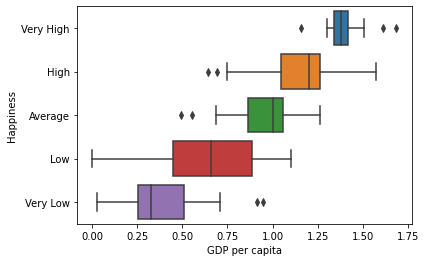

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

## GDP per capita vs. Happiness 
sns.boxplot(x= "GDP per capita", y="Happiness",
              order = ['Very High', 'High', 'Average', 'Low', 'Very Low'],
                        data=df)

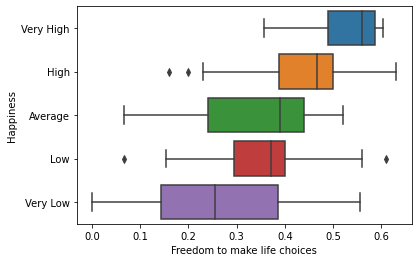

In [33]:
## Freedom vs. Happiness
sns.boxplot(x= "Freedom to make life choices", y="Happiness",
              order = ['Very High', 'High', 'Average', 'Low', 'Very Low'],
                        data=df)

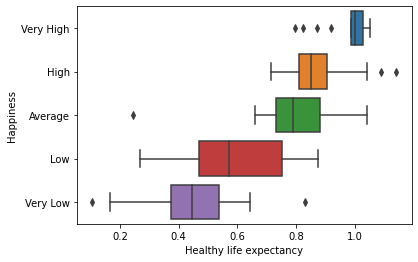

In [45]:
## Healthy life expectancy vs. Happiness
sns.boxplot(x= "Healthy life expectancy", y= "Happiness",
              order = ['Very High', 'High', 'Average', 'Low', 'Very Low'],
                        data=df)

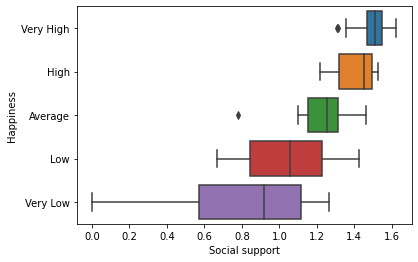

In [46]:
## Social support vs. Happiness
sns.boxplot(x= "Social support", y= "Happiness",
              order = ['Very High', 'High', 'Average', 'Low', 'Very Low'],
                        data=df)

In the box plots above, I chose the predictor variables/features to be GDP per capita, Freedom to make life choices, Healthy life expectancy, and Social support based off of my own judgment and assumptions. For example, we can see that with countries with higher GDP per capita, the average level of happiness is higher in those countries. In the countries that are lower in GDP per capita tend to have very low levels of happiness. I chose GDP per capita as an explanatory feature because a higher GDP per capita usually indicates a higher quality of life which should positively correlate with a higher level of happiness. Out of all of the explanatory features, I think that the top 3 most important would be GDP per capita, Healthy life expectancy, and Social support because these variables has a smalle variance in comparison to Freedom to make life choice.

### Examine features that predict happiness categories using one or more models that allow for automatic feature selection. -- Explain any meaningful findings

#### Principal Component Analysis (PCA)

In [42]:
from sklearn.decomposition import PCA

X_train_ = preprocessor(X_train)
pca = PCA(n_components=6)
pca.fit(X_train_)
components = pca.components_

df1 = pd.DataFrame(X_train_)

pca.explained_variance_

array([3.61970037, 1.50293369, 0.84846365, 0.63068691, 0.51553714,
       0.40253738])

In [43]:
pca.explained_variance_ratio_

array([0.41600573, 0.1727295 , 0.09751242, 0.07248373, 0.05924977,
       0.04626291])

In [44]:
df1.pca = pd.DataFrame(components, columns = df1.columns)
df1.pca

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,-0.469820,-0.450864,-0.477283,-0.349056,-0.037379,-0.270050,0.287854,0.159687,-0.016023,-0.008481,-0.120490,-0.014692,-0.014692,-0.005011,-0.007914,-0.008542,-0.008885,0.008502,-0.007138,-0.053801,-0.008813,0.016056,-0.018089,0.151184,-0.002798,-0.040058
1,-0.189690,-0.143455,-0.167612,0.381650,0.680263,0.508765,0.105649,0.062002,-0.029668,0.025580,-0.082531,0.024617,0.024617,0.017484,-0.021381,-0.056407,-0.038904,-0.023175,0.009236,0.023457,0.052768,0.009604,-0.071963,0.085177,-0.032895,0.022381
2,0.230795,0.062043,0.192806,-0.265952,0.113509,0.106760,0.839548,-0.182732,-0.028144,0.108148,0.095061,0.007667,0.007667,-0.015298,0.003724,-0.001919,-0.030200,0.013386,0.002056,0.033450,-0.002974,0.072831,0.037996,-0.196118,0.049865,0.025533
3,-0.022981,0.149302,0.073165,-0.071525,0.641901,-0.659929,-0.126548,-0.185828,0.078681,0.101562,0.011903,-0.006318,-0.006318,0.040407,-0.005208,0.030060,0.082718,-0.051589,-0.004037,-0.060772,0.069904,0.031921,0.092113,-0.134238,-0.035462,-0.049498
4,0.108180,-0.379438,0.223844,-0.654582,0.217694,0.314505,-0.399156,-0.072806,-0.106184,0.086435,0.080966,0.011589,0.011589,-0.025190,0.018655,-0.004230,-0.106725,0.000030,0.000541,0.010156,0.010247,-0.008949,0.041796,-0.072836,0.091672,0.033245
5,0.064991,-0.352578,0.099776,0.272635,-0.153435,-0.070607,-0.023629,-0.192392,0.030646,0.580823,-0.408604,-0.010474,-0.010474,0.049179,0.066838,-0.076480,0.030475,-0.001144,0.000171,-0.143106,0.056059,0.064143,-0.117038,-0.191247,0.344605,-0.071980


Principal component analysis is a technique used used to examine the interrelations among a set of variables. The goal of using PCA is to find the principal components or the best features that can describe the data points (with the least amount of components). In doing so, it reduces the dimensionality of the data frame. It produces a set of vital components that can best explain your data while also minimizing the information loss that occurs when getting rid of the other components. 

The PCA model above tells us that the 2 most vital determinants of happiness are GDP per capita and Social support (as predicted above). 

#### Recursive Feature Elimination with Logistic Regression 

In [52]:
from sklearn.feature_selection import RFE

model = LogisticRegression()
rfe = RFE(model, 3)
fit = rfe.fit(preprocessor(X_train), y_train_labels)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Rankings: %s" % (fit.ranking_))


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_features_to_select=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Num Features: 3
Selected Features: [ True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False]
Feature Rankings: [ 1  1  1  2 11 14  3 20 19  6 17 22 23 12 21 16 10 15 24 18 13  7  5  9
  8  4]


From the recursive feature elimination analysis using logistic regression, we see that the first 3 selected features are ranked as 1 (GDP per capita, Social support, Healthy life expectancy). The feature that is ranked 2nd is Freedom to make life choices which was I originally hypothesized to be an important determinant of happiness.

### Run at least three prediction models to try to predict World Happiness well. -- Discuss which models performed better and point out relevant hyper-parameter values for successful models.

#### Model 1: Logistic Regression

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score 

logreg = LogisticRegression( solver='liblinear', penalty = 'l2', 
                                max_iter=10000)
logreg.fit(preprocessor(X_train), y_train_labels)

print("cross_validation_score = {:.5f}".format
      (np.mean(cross_val_score(logreg, preprocessor(X_train), y_train_labels))))

print("Training set score: {:.5f}".format(logreg.score(preprocessor(X_train), y_train_labels)))
print("Test set score: {:.5f}".format(logreg.score(preprocessor(X_train), y_train_labels)))
print("CV score: {:.5f}".format(np.mean(cross_val_score(logreg, preprocessor(X_train), y_train_labels))))

cross_validation_score = 0.62476
Training set score: 0.79808
Test set score: 0.79808
CV score: 0.62476


In [35]:
## gridsearchCV
param_grid = { 'penalty': ['l1','l2'], "C":[0.001, 0.01, 0.1, 1, 10, 100], 'max_iter':[50, 100, 500, 1000, 5000]}
grid = GridSearchCV(LogisticRegression(penalty='l2', solver='liblinear')
                     ,param_grid=param_grid, cv=15)
grid.fit(preprocessor(X_train), y_train_labels)

print("best mean cross-validation score: {:.5f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))
print("test-set score: {:.5f}".format(grid.score(preprocessor(X_train), y_train_labels)))

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

best mean cross-validation score: 0.66508
best parameters: {'C': 0.1, 'max_iter': 50, 'penalty': 'l2'}
test-set score: 0.75000


In [36]:
logreg1 = LogisticRegression(penalty = 'l2', 
                               solver='liblinear', max_iter=50, C = 0.1)
logreg1.fit(preprocessor(X_train), y_train_labels)
print("logreg.coef_: {}".format(logreg1.coef_))
print(X_train.columns)

logreg.coef_: [[-0.01885065  0.01300432  0.14469501 -0.11031025 -0.13013698 -0.28932917
  -0.00230502 -0.23066175 -0.230327   -0.15311243 -0.13969253 -0.03408757
  -0.03408757  0.09083126 -0.00547153 -0.02241663 -0.21409331  0.15952221
  -0.0162337  -0.18482711  0.0214566  -0.11023348  0.1858321  -0.39018395
  -0.14969528 -0.11828089]
 [ 0.16550905  0.35059602  0.20303762  0.15497557 -0.27248317 -0.34965577
  -0.10967621 -0.39288773  0.13949217 -0.13741488 -0.27246417 -0.05767443
  -0.05767443  0.06478637  0.05493271  0.11056457  0.17730158 -0.09502928
  -0.03780941 -0.02258119  0.01219556 -0.08110517 -0.1774851  -0.29785845
  -0.18822434 -0.18296245]
 [-0.21325672 -0.14510951 -0.29463294  0.03964838 -0.2022978  -0.11684863
  -0.37008602 -0.10059833 -0.2032475  -0.07467315 -0.40151692 -0.02535414
  -0.02535414 -0.11236396 -0.07489563 -0.13237664 -0.19091066 -0.11647361
  -0.01233683 -0.11648012  0.00249537  0.09526072 -0.0839282   0.01587528
   0.01483035 -0.06873195]
 [ 0.44077071  0.

At first, I run a logistic regression that results in a test set score of 0.798. However, to further explore the best parameters for the regression, I run a GridSearchCV. The best parameters produced by the grid search were 'C' = 0.1, 'max_iter' = 50 and a 'penalty' = l2. From that, I ran a L2 penalized logistic regression utilizing the best parameters. Using a L2 penalized logistic regression means that the model zeroes out all of the features that are not as important or do not contribute as much to predicting the target variable, happiness categories. The variables that have a larger coefficient are the main cotributors to predicting the happiness categories.

Prior to running GridSearch CV, the Logistic Regression test score is 0.798 with a cross validation score of 0.625. The test score for Logistic Regression with Gridsearch CV is 0.75.

#### Model 2: Support Vector Machines

In [53]:
svc = SVC(kernel='linear', C=10) 
svc.fit(preprocessor(X_train), y_train_labels) 
svc.score(preprocessor(X_train), y_train_labels)

print("Training set score: {:.3f}".format(svc.score(preprocessor(X_train), y_train_labels)))
print("Test set score: {:.3f}".format(svc.score(preprocessor(X_train), y_train_labels)))
print("SVM .coef_: {}".format(svc.coef_))

Training set score: 0.904
Test set score: 0.904
SVM .coef_: [[-2.51053631 -0.90427841 -1.28518306 -0.72876943 -0.80788065 -0.05627842
   2.86710409  0.         -1.15862735  1.13098788  0.02763946  0.
   0.         -1.02882995 -0.12871091 -0.76668895 -1.15862735  0.
   0.         -0.97271328  1.39887676  0.          1.7670417   0.
   0.88965199  0.        ]
 [ 3.34951828  1.45159881  1.28919851  1.36555233 -0.12235892  1.17981253
   3.75733563  0.10364672 -0.78048149 -0.17078471  0.84761948  0.
   0.          3.35226256  0.          2.48101404 -0.78048149  2.07225795
   0.          0.          0.05068127 -1.76655443 -1.63339456 -1.96861123
  -1.80717411  0.        ]
 [-2.43773118 -1.48909609  0.54321131  0.25655624 -0.34681581 -0.16197724
   1.05798872  0.         -0.50499263  0.07020495  0.43478769  0.
   0.          0.          0.          0.83071044 -0.50499263  0.
   0.          0.          0.11729242  0.          0.1882721   0.
  -0.04708747 -0.58419486]
 [ 3.61349834 -0.01768124 -

In [54]:
param_grid = {'C': [1, 5, 10, 50],
              'gamma': [0.0001, 0.001, 0.01, 1, 10, 100]}
grid = GridSearchCV(svc, param_grid)

%time grid.fit(preprocessor(X_train), y_train_labels)
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)

CPU times: user 696 ms, sys: 6.36 ms, total: 702 ms
Wall time: 765 ms
{'C': 1, 'gamma': 0.0001}
SVC(C=1, gamma=0.0001, kernel='linear')
0.7014285714285713


For my next model, I employ the Support Vector Machines model. The first time I run this model, I get a test score of 0.904. However, after running Gridsearch CV on it, the score comes out to be 0.701 with the best parameters being 'C' = 1 and 'gamma' = 0.0001.

#### Model 3: Decision Tree Classifier

In [55]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=1)
tree.fit(preprocessor(X_train), y_train_labels) 
tree.score(preprocessor(X_train), y_train_labels)

print("Training set score: {:.4f}".format(tree.score(preprocessor(X_train), y_train_labels)))
print("Test set score: {:.4f}".format(tree.score(preprocessor(X_train), y_train_labels)))

Training set score: 1.0000
Test set score: 1.0000


In [56]:
param_grid = {'max_depth' : [5, 6, 7, 8, 9]}

grid = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, cv=10)
grid.fit(preprocessor(X_train), y_train_labels)

print("best parameters: {}".format(grid.best_params_))
print("test-set score: {:.3f}".format(grid.score(preprocessor(X_train), y_train_labels)))

best parameters: {'max_depth': 7}
test-set score: 0.942


For my last model, I chose to use the Decision Tree Classifier. After running this model with Gridsearch CV, I get a test set score of 0.942, which is the best score out of all of my models.

### [10 pts] Submit your best model to the leader board for the World Happiness AI Model Share competition created for this class. Remember to use the instructions on the World Happiness Model Submission Guide notebook, including the specific code to load your train and tests sets

In [78]:
## best model Decision Tree Classifier 
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=1)
tree.fit(preprocessor(X_train), y_train_labels) 
tree.score(preprocessor(X_train), y_train_labels)

print("Training set score: {:.4f}".format(tree.score(preprocessor(X_train), y_train_labels)))
print("Test set score: {:.4f}".format(tree.score(preprocessor(X_train), y_train_labels)))

param_grid = {'max_depth' : [5, 6, 7, 8, 9]}

grid = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, cv=10)
grid.fit(preprocessor(X_train), y_train_labels)

print("best parameters: {}".format(grid.best_params_))
print("test-set score: {:.3f}".format(grid.score(preprocessor(X_train), y_train_labels)))

Training set score: 1.0000
Test set score: 1.0000
best parameters: {'max_depth': 7}
test-set score: 0.942


In [79]:
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"") 

Your preprocessor is now saved to 'preprocessor.zip'


In [80]:
# Save sklearn model to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

feature_count=preprocessor(X_test).shape[1] #Get count of preprocessed features
initial_type = [('float_input', FloatTensorType([None, feature_count]))]  # Insert correct number of preprocessed features

onnx_model = model_to_onnx(gridmodel, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)

with open("gridmodel.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [81]:
#Set credentials using modelshare.org username/password

from aimodelshare.aws import set_credentials

#This is the unique rest api that powers this World Happiness Classification Playground -- make sure to update the apiurl for new competition deployments
apiurl="https://c3maq947kb.execute-api.us-east-1.amazonaws.com/prod/m"

set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [82]:
#Instantiate Competition
import aimodelshare as ai
mycompetition= ai.Competition(apiurl)

In [83]:
#Submit Best Model: 

#-- Generate predicted values (Best Model)
prediction_labels = model.predict(preprocessor(X_test))

# Submit Best Model to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): best model, decision tree, nikkigsak
Provide any useful notes about your model (optional): this is my best model from HW 1

Your model has been submitted as model version 139

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:1289
